(getting_started)=
# 🚀 Getting Started


:::{note}
This example shows the interactive capabilities of Matplotlib backends, and this will not appear in the static documentation. Please run this code on your machine to see the interactivity.
:::

This tutorial guides users through analyzing, visualizing, and generating synthetic birdsongs using the `wavesongs` Python package. 

::::{admonition} Google Colab Execution
:class: dropdown

If you are using Google Colabinstall the pacakge via pypi with the following code:

:::{code} bash
! git clone https://github.com/wavesongs/wavesongs
! pip install wavesongs
# enable hird party widgets (ipympl)
from google.colab import output
output.enable_custom_widget_manager()
:::

In addition, you have to change the results and audio folder to:
:::{code} python
audios = "/content/wavesongs/assets/audio"
results = "/content/wavesongs/assets/audio/results"
:::

This is because in Google Colab all is downloaded at the `contents` folder. 

:::{caution}
If you encounter an error message, reset the kernel and run the above cell again. After that, everything should work successfully. Ensure that the audios and results variables are correctly set to the appropriate paths in your environment.
:::

::::


## Libraries

Import the required classes and functions from `wavesongs`:

In [1]:
%matplotlib ipympl

from wavesongs.utils.paths import ProjDirs   # Manages project files
from wavesongs.objs.syllable import Syllable # Syllable ws objects
from wavesongs.objs.song import Song         # Song ws objects
from wavesongs import plot                   # Plotting utilities
from wavesongs.utils.tools import get_roi    # Data extraction tools

:::{important}
The first line changes the Matplotlib backend to [ipympl](https://matplotlib.org/ipympl/), enabling interactive plots. For more information about interactive plots, visit the official Matplotlib documentation on [interactive figures](https://matplotlib.org/stable/users/explain/figure/interactive.html). 
If you are using a Python or IPython terminal, omit this line.
:::

## Project Directory

To use objects like `Syllable` or `Song`, first define a project directory using a `ProjDirs` object. This object manages generated files such as images, audio files, and CSVs. The default project structure is:

:::{code-block} text
📁 project_root
└── 📁 assets
    ├── 📁 audios
    |    ├── <audio sample files>
    |    └── <meta data>.csv
    └── 📁 results
        ├── 📁 audios
        ├── 📁 figures
        └── 📁 mg_params
:::

In [ ]:
audios = "./assets/audios"
results = "./assets/results"
proj_dirs = ProjDirs(audios=audios, results=results)

You can check the audio files found with the `find_audios` method

In [ ]:
proj_dirs.find_audios()

['574179401 - Zonotrichia Capensis.wav',
 'XC388622 - Ocellated Tapaculo - Acropternis orthonyx.mp3',
 'XC553918.mp3',
 'XC11293.mp3',
 'XC542500.mp3',
 'XC842155.mp3',
 'XC380282.mp3']

Here are the audio samples that come with the package, the first two, and the samples downloaded from Xeno Canto in the [](./DownloadSamples.ipynb) tutorial. These audios are stored in a folder with the name `zonotrichia_capensis` with their respective metadata in `metadata.csv`.

## Song Object

Next, create a `Song` instance with the project directory and a file name. In this tutorial, we use the audio file `574179401 - Zonotrichia Capensis.wav` located at `assets/audio/` but you can use your own records or download samples from Xeno Canto.

Once the song is defined, compute its acoustic features. You can specify parameters such as the Fast Fourier Transform (FFT) window and fundamental frequency (FF) method.

To display the spectrogram, use the `plots` module and the `spectrogram_waveform` function.

The name assigned to the song and syllables, "Copetón," is the common name for Zonotrichia capensis in Colombia.

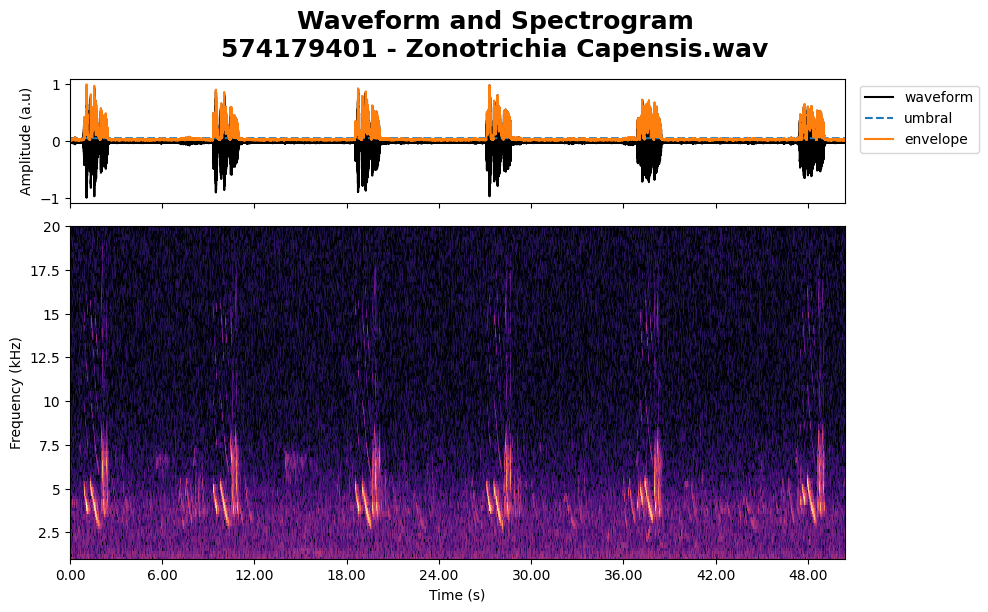

In [17]:
copeton_song = Song(proj_dirs, file_id="574179401")
copeton_song.acoustical_features(umbral_FF=1.4, NN=256)

# Display the song's spectrogram and waveform
plot.spectrogram_waveform(copeton_song, save=False)

In [4]:
copeton_song.play()

:::{tip}
Long audio files can slow down plot response. A best practice is to define a **region of interest (RoI)**, such as a complete birdsong.
:::

## Birdsong

To select a specific time interval, set `select_time=True` and define the start and end of the RoI.

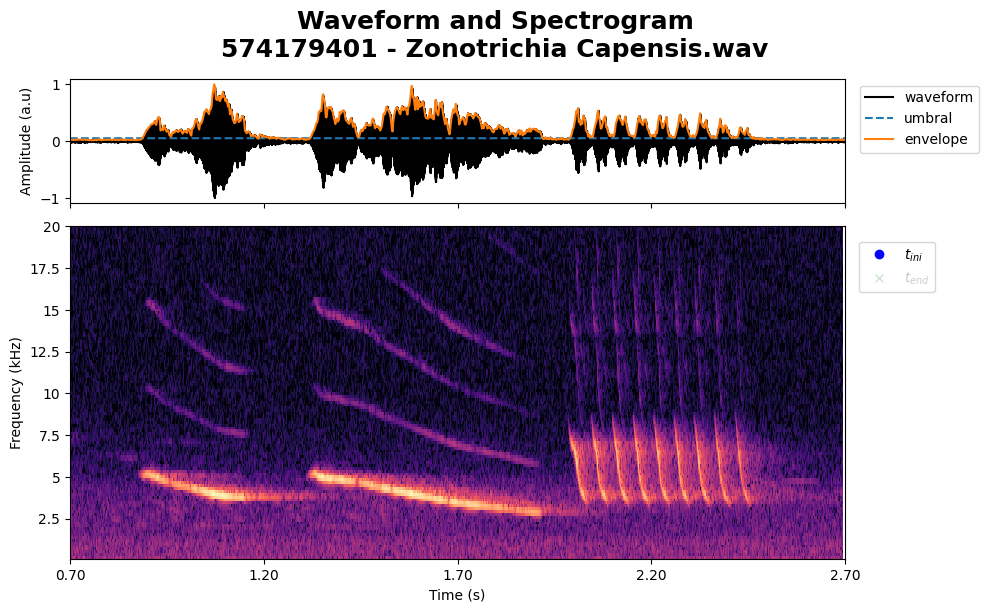

In [18]:
tlim_roi = (0.7, 2.7) # Time interval for the RoI

copeton_syllable = Song(proj_dirs, file_id="574179401", tlim=tlim_roi)
copeton_syllable.acoustical_features(umbral_FF=1.4, NN=256, ff_method="yin", flim=(1e2, 2e4))

klicker_times = plot.spectrogram_waveform(copeton_syllable, tlim=tlim_roi, select_time=True, save=False)

In [9]:
copeton_syllable.play()

This function returns an array of measurements, where each element is a vector containing time and frequency range values.

:::{warning}
If no selection is made, an error will appear.
:::

:::{note}
The fundamental frequency is calculated using the YIN or PYIN algorithm. While the algorithm generally provides accurate results, the initial portion of the signal may not be computed as effectively.
:::

In [10]:
data = get_roi(klicker_times)
tlim, flim = data[0] # index = 0: first pair
# Add the initial time from the syllable
t0 = tlim[0] + copeton_syllable.t0_bs
tend = tlim[1] + copeton_syllable.t0_bs
print(f"Region of Interest: (tini = {t0:.4f} s, tend = {tend:.4f} s)")

Region of Interest: (tini = 0.8781 s, tend = 1.3006 s)


## Syllable

Define a syllable object within the selected RoI

Image save at ../../assets/results/figures/574179401-ZonotrichiaCapensis-0-intro-down


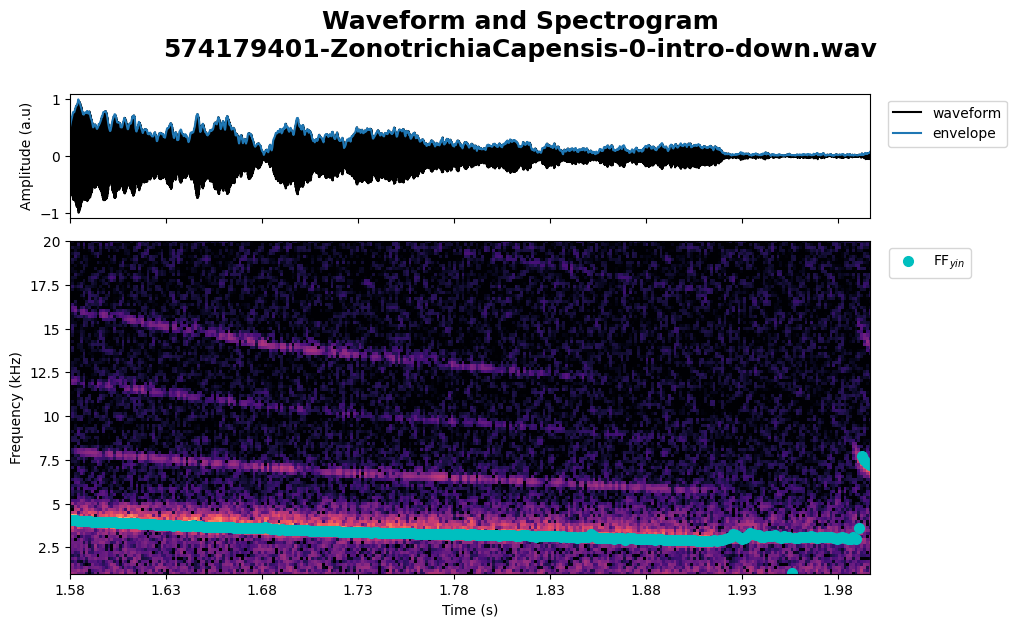

In [19]:
# tlim = (0.8781, 1.3006) # For testing purpose
copeton_syllable_0 = Syllable(obj=copeton_syllable, tlim=tlim, type="intro-down", no_syllable="0")
copeton_syllable_0.acoustical_features(NN=256)

# Display the syllable's spectrogram and waveform
plot.spectrogram_waveform(copeton_syllable_0, ff_on=True, save=True)

In [12]:
copeton_syllable_0.play()

In [13]:
# Write audio
copeton_syllable_0.write_audio()

Audio saved at ../../assets/results/audios/574179401-ZonotrichiaCapensis-syllable-0.wav.


## Synthetic Syllable

To generate a synthetic syllable use the optimizer module, `wavesongs.optimizer`, which solves a minimization problem to find the optimal motor gesture coefficient such that generate the most similar syllable.

### Optimal Coefficients

The birdsong model consists of four coefficients that define the labial tension ($\beta$) and air-sac pressure ($\alpha$): ($a_0, b_0, b_1, b_2$). Although both variables change over time, but we are just interested in the coefficients.

In [15]:
from wavesongs import optimizer

optimal_z = optimizer.optimal_params(syllable=copeton_syllable_0, Ns=10, full_output=True)
print(f"\nOptimal model values (alpha and beta coefficients):\n\t{optimal_z}")


Computing a0*...
Optimization terminated successfully.
         Current function value: 0.013981
         Iterations: 1
         Function evaluations: 2
	 Optimal values: a_0=0.0010, t=0.76 min

Computing b0*, b1*, and b2*...
Optimization terminated successfully.
         Current function value: 0.003349
         Iterations: 37
         Function evaluations: 75
	 Optimal values: b_0=-0.1973, b_2=1.2033, t=20.21 min
Optimization terminated successfully.
         Current function value: 0.003350
         Iterations: 13
         Function evaluations: 27
	 Optimal values: b_1=0.9992, t=6.27 min

Time of execution: 27.24 min

Optimal model values (alpha and beta coefficients):
	{'a0': 0.00105, 'b0': -0.19726, 'b1': 0.99924, 'b2': 1.20333}


### Solution

Now, generate and visualize the synthetic syllable using the computed optimal coefficients, `optimal_z`.

Image save at ../../assets/results/figures/synth-574179401-ZonotrichiaCapensis-0-intro-down


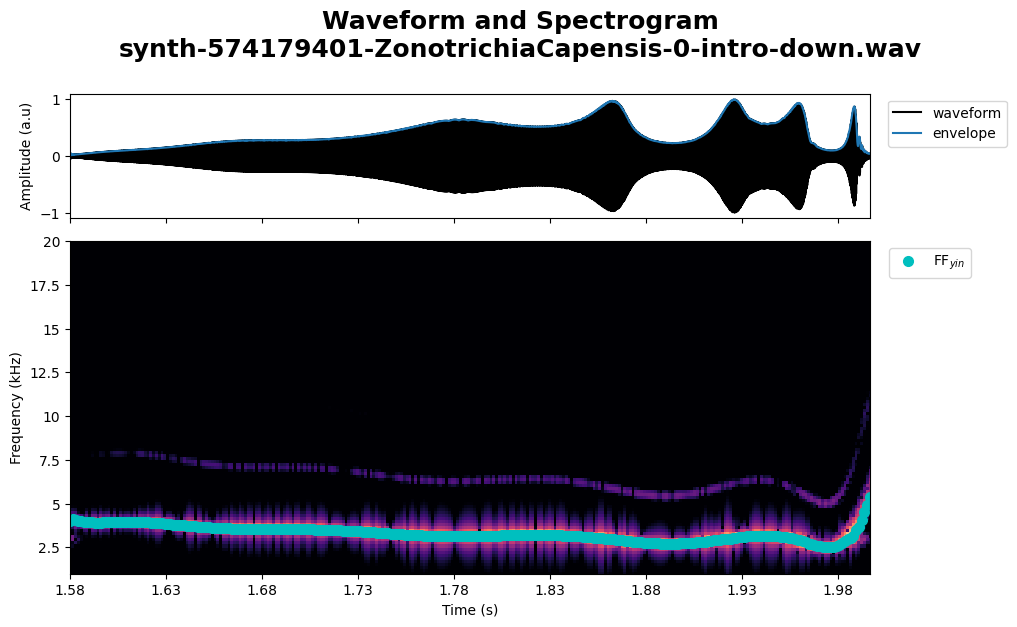

In [20]:
# optimal_z = {'a0': 0.00105, 'b0': -0.19726, 'b1': 0.99924, 'b2': 1.20333} # Testing purpose
synth_copeton_syllable_0 = copeton_syllable_0.solve(z=optimal_z, method="best")
plot.spectrogram_waveform(synth_copeton_syllable_0, ff_on=True, save=True)

In [17]:
synth_copeton_syllable_0.play()

In [18]:
# Write synthetic sample
synth_copeton_syllable_0.write_audio()

Audio saved at ../../assets/results/audios/synth-574179401-ZonotrichiaCapensis-synth-syllable-0.wav.


In the `solve()` method, there are two approaches available for generating synthetic songs:

1. **`best` Method**: The labial tension is calculated using the formula:  
   
   $$
   \beta(t) = b_0 + b_1 \cdot \tilde{FF} + b_2 \cdot \tilde{FF}^2
   $$  
   
   where $\tilde{FF}$ represents the fundamental frequency normalized by $10^4$ Hz.

2. **`fast` Method**: The labial tension is computed as:  
   
   $$
   \beta(t) = b_0 + b_1 \cdot t + b_2 \cdot t^2
   $$  
   
   where $t$ denotes time.

Additionally, you can export and import the entire `Syllable` object for further use or analysis. 

#### Saving Curves

##### Export

Exporting syllable parameters

In [19]:
synth_copeton_syllable_0.export_mg(export_curves=True)

Curves arrays saved at ../../assets/results/mg_params/synth-574179401-ZonotrichiaCapensis-0-curves.csv
Motor gesture parameters saved at ../../assets/results/mg_params/574179401-ZonotrichiaCapensis-0-mg.csv.


##### Import

Importing parameters from csv file

Image save at ../../assets/results/figures/synth-574179401-ZonotrichiaCapensis-0-intro-down


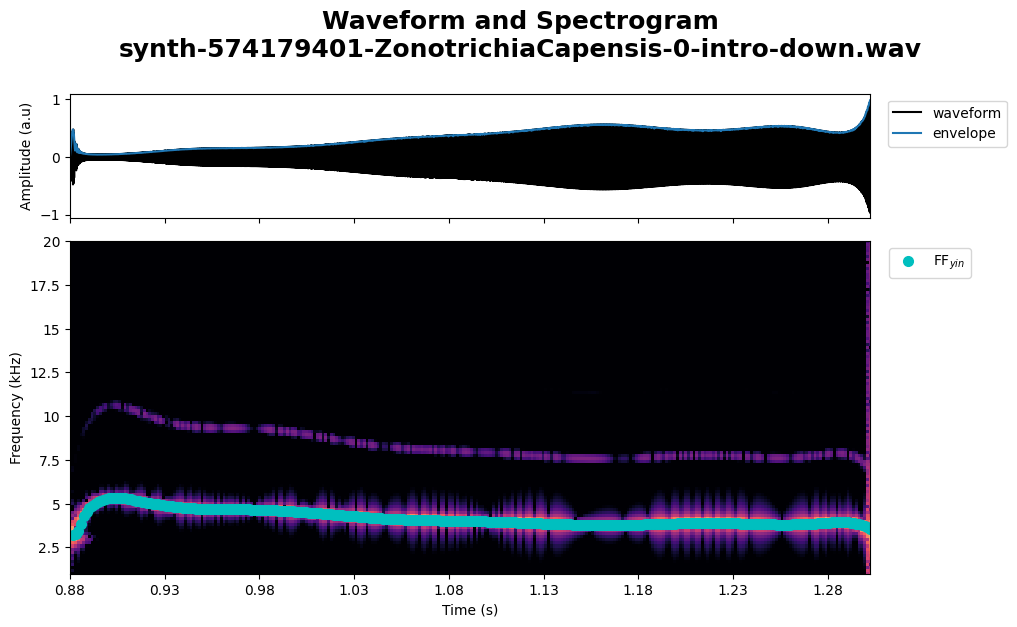

In [21]:
proj_dirs = ProjDirs(audios="../../assets/audio", results="../../assets/results")
imported_synth_copeton_syllable_0 = proj_dirs.import_mg("574179401", no_syllable=0)
plot.spectrogram_waveform(imported_synth_copeton_syllable_0, ff_on=True)

This process generates a CSV file containing all the parameters of the `Syllable`. The file name ends with `"mg"`. If the `best` method is selected, an additional file will be created during export, ending with `"curve"`. This file includes the curve arrays for time ($t$), air-sac pressure ($\alpha(t)$), and labial tension ($\beta(t)$). By default, both files are stored in the directory `assets/results/mg_params/`.

In [21]:
imported_synth_copeton_syllable_0.play()

### Plots
#### Comparing Samples

Image save at 574179401-ZonotrichiaCapensis-0-intro-down-SoundAndSpectros.png


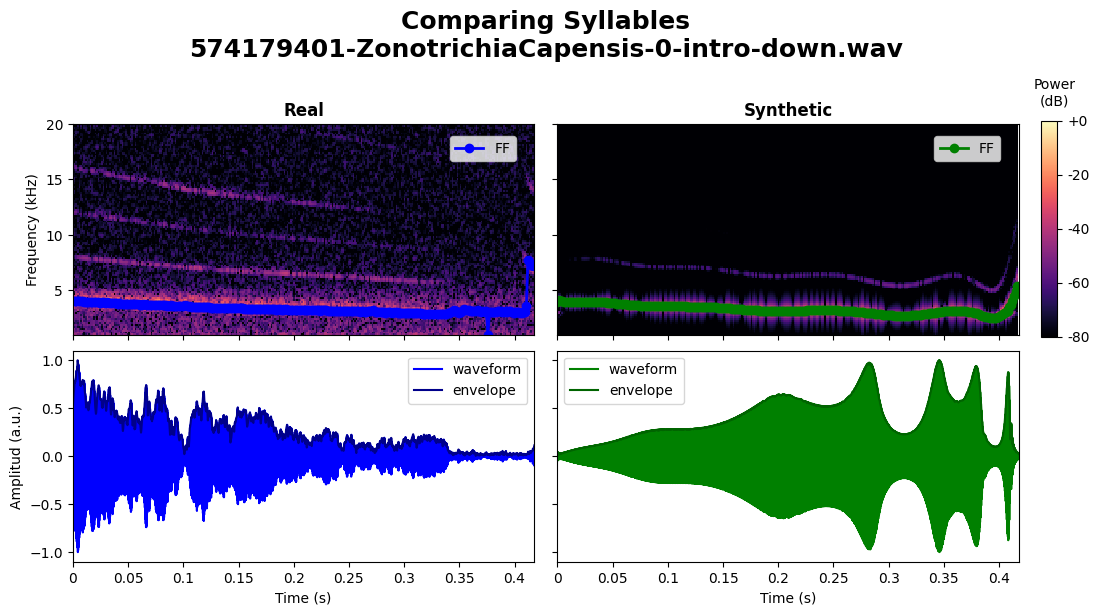

In [22]:
plot.syllables(copeton_syllable_0, synth_copeton_syllable_0, ff_on=True)

#### Motor Gesture

Image save at synth-574179401-ZonotrichiaCapensis-0-intro-down-mg_params.png


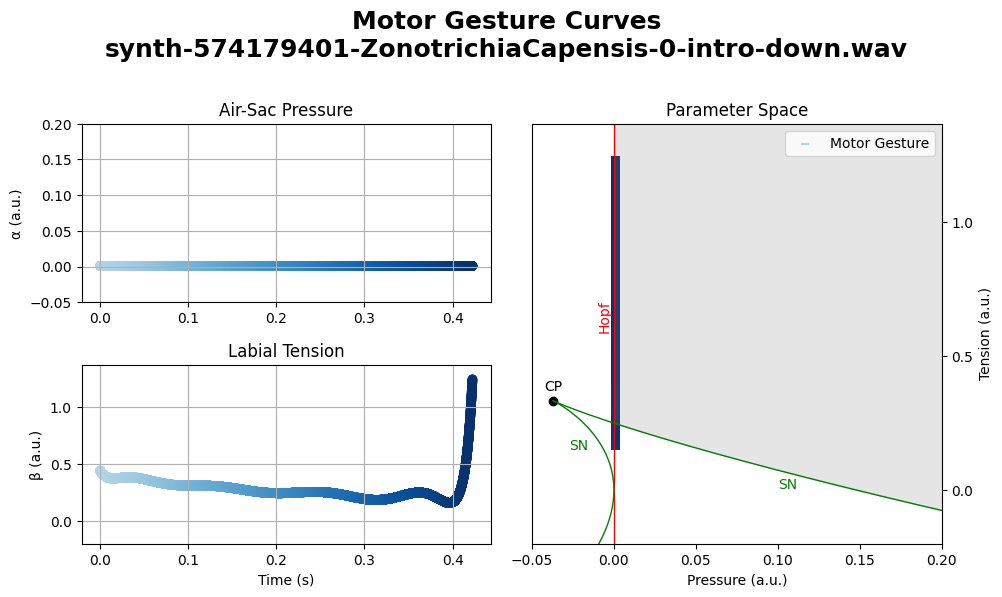

In [23]:
plot.alpha_beta(synth_copeton_syllable_0)

#### Physical Variables

Image save at synth-574179401-ZonotrichiaCapensis-0-intro-down-PhysicalVariables.png


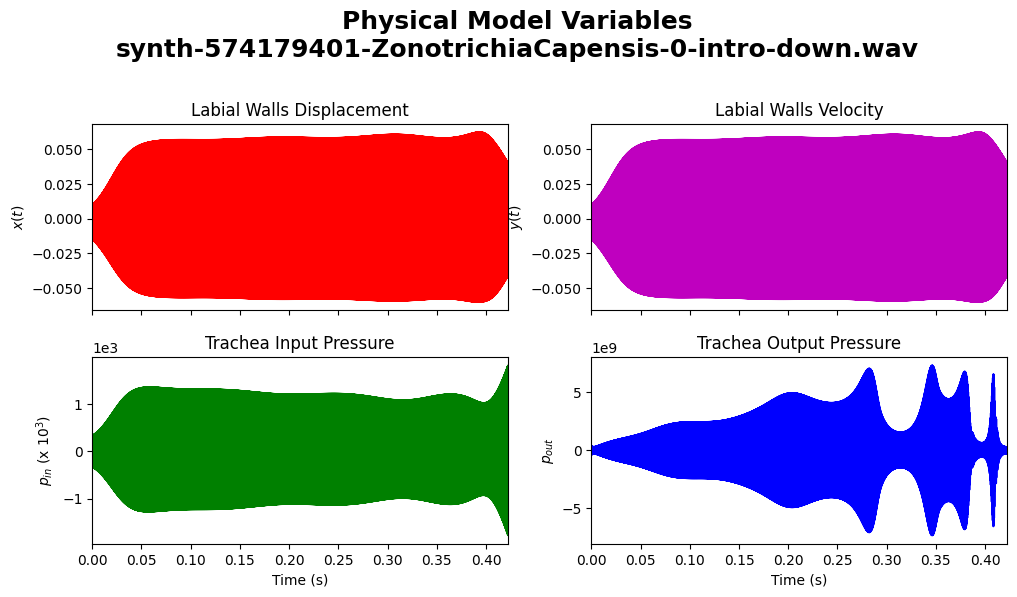

In [24]:
plot.phsyical_variables(synth_copeton_syllable_0)

#### Score Variables

Image save at 574179401-ZonotrichiaCapensis-0-intro-down-ScoringVariables.png


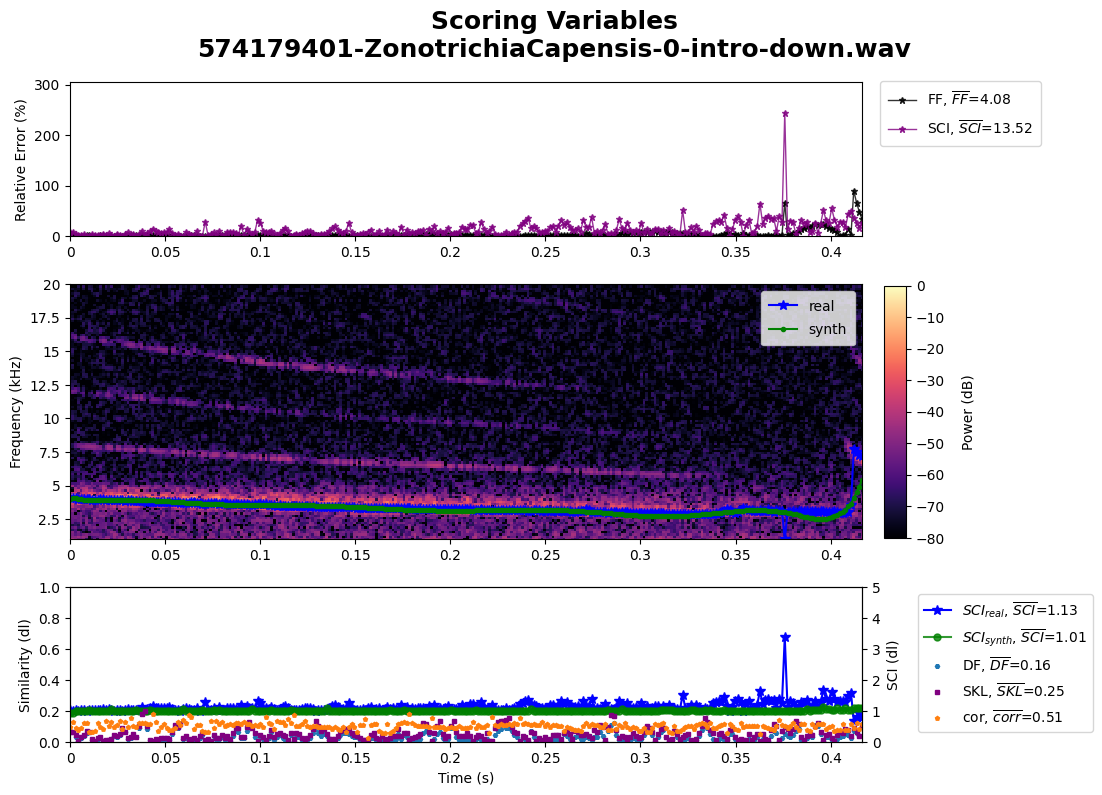

In [25]:
plot.scores(copeton_syllable_0, synth_copeton_syllable_0, save=True)

---

This tutorial introduced **WaveSongs** for bioacoustic analysis, covering setup, song processing, spectrogram visualization, and synthetic syllable generation. By following these steps, you can analyze bird vocalizations and optimize synthetic models for research or educational purposes.

Happy coding! 🎵🔬